https://data102.org/ds-102-book/content/chapters/02/02_hierarchical_models.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import arviz as az

import jax
from jax import random
import jax.numpy as jnp

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.infer import Predictive

plt.style.use("bmh")

# save mcmc results: mcmc_dict[model_name] = model_mcmc
try:
    mcmc_dict
except NameError:
    mcmc_dict = dict()

# seed for reproducibility
seed_split = 42
seed_jax_rng = random.PRNGKey(0)

# parameters settings
num_samples = 2000    # #samples from MCMC
num_warmup = 1000     # #warmups
num_pp_samples = 500  # #samples for posterior
num_chains = 2        # # MCMC chains
num_comps = 3         # #components in GMM

# try to use more device count for more speed up
dev_cnt = jax.local_device_count()
dev_mcmc = num_chains if dev_cnt >= num_chains else dev_cnt
numpyro.set_host_device_count(dev_mcmc)

# run model utility function
def _run_model(model, data, seed = seed_jax_rng, num_warmup = num_warmup, num_samples = num_samples, num_chains = num_chains, init_params = None):
    _, rng_key = random.split(seed)
    mcmc = MCMC(
        NUTS(model),  # can include more sophisticated optimization settings
        num_warmup = num_warmup,
        num_samples = num_samples,
        num_chains = num_chains
    )

    mcmc.run(
        rng_key,
        **data,
        extra_fields=('energy',),  # to enable energy plot
        init_params = init_params
    )
    return mcmc

/opt/homebrew/Caskroom/miniforge/base/envs/bda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('KidneyCancerClean.csv', skiprows = 4)
df = df.loc[:, ['state', 'Location', 'dc', 'dc.2', 'pop', 'pop.2']]  # population & cancer death for two time periods
df['rate'] = df['dc'] / df['pop']
df.head()

# `Location` = city + `state` => FIPS code (`fips`)


,state,Location,dc,dc.2,pop,pop.2,rate
0,ALABAMA,"Autauga County, Alabama",2,1,61921,64915,0.000032
1,ALABAMA,"Baldwin County, Alabama",7,15,170945,195253,0.000041
2,ALABAMA,"Barbour County, Alabama",0,1,33316,33987,0.000000
3,ALABAMA,"Bibb County, Alabama",0,1,30152,31175,0.000000
4,ALABAMA,"Blount County, Alabama",3,5,88342,91547,0.000034


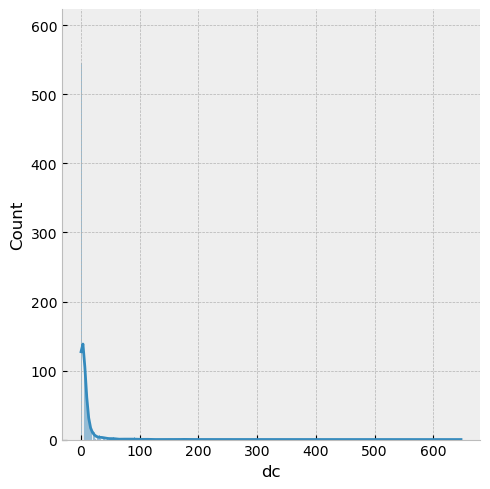

In [3]:
sns.displot(df['dc'], kde=True)

In [4]:
df.describe()

,dc,dc.2,pop,pop.2,rate
count,3110.000000,3110.000000,3.110000e+03,3.110000e+03,3110.000000
mean,7.527974,8.359164,1.550087e+05,1.606611e+05,0.000050
std,23.095402,23.765728,4.722345e+05,4.972750e+05,0.000044
min,0.000000,0.000000,2.580000e+02,2.670000e+02,0.000000
25%,1.000000,1.000000,2.238250e+04,2.213000e+04,0.000023
50%,2.000000,3.000000,4.762800e+04,4.806950e+04,0.000045
75%,6.000000,7.000000,1.146262e+05,1.179355e+05,0.000070
max,647.000000,598.000000,1.526640e+07,1.660789e+07,0.000452


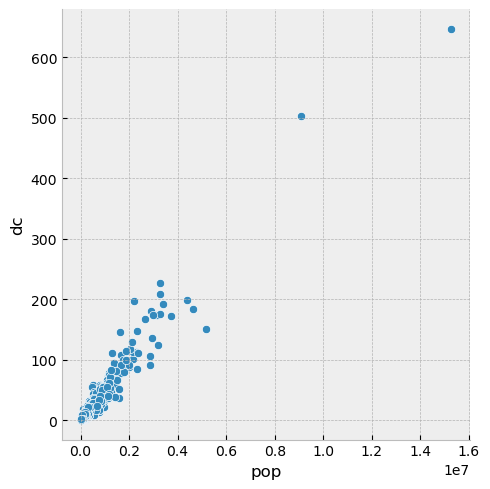

In [5]:
sns.relplot(x = 'pop', y = 'dc', data = df)

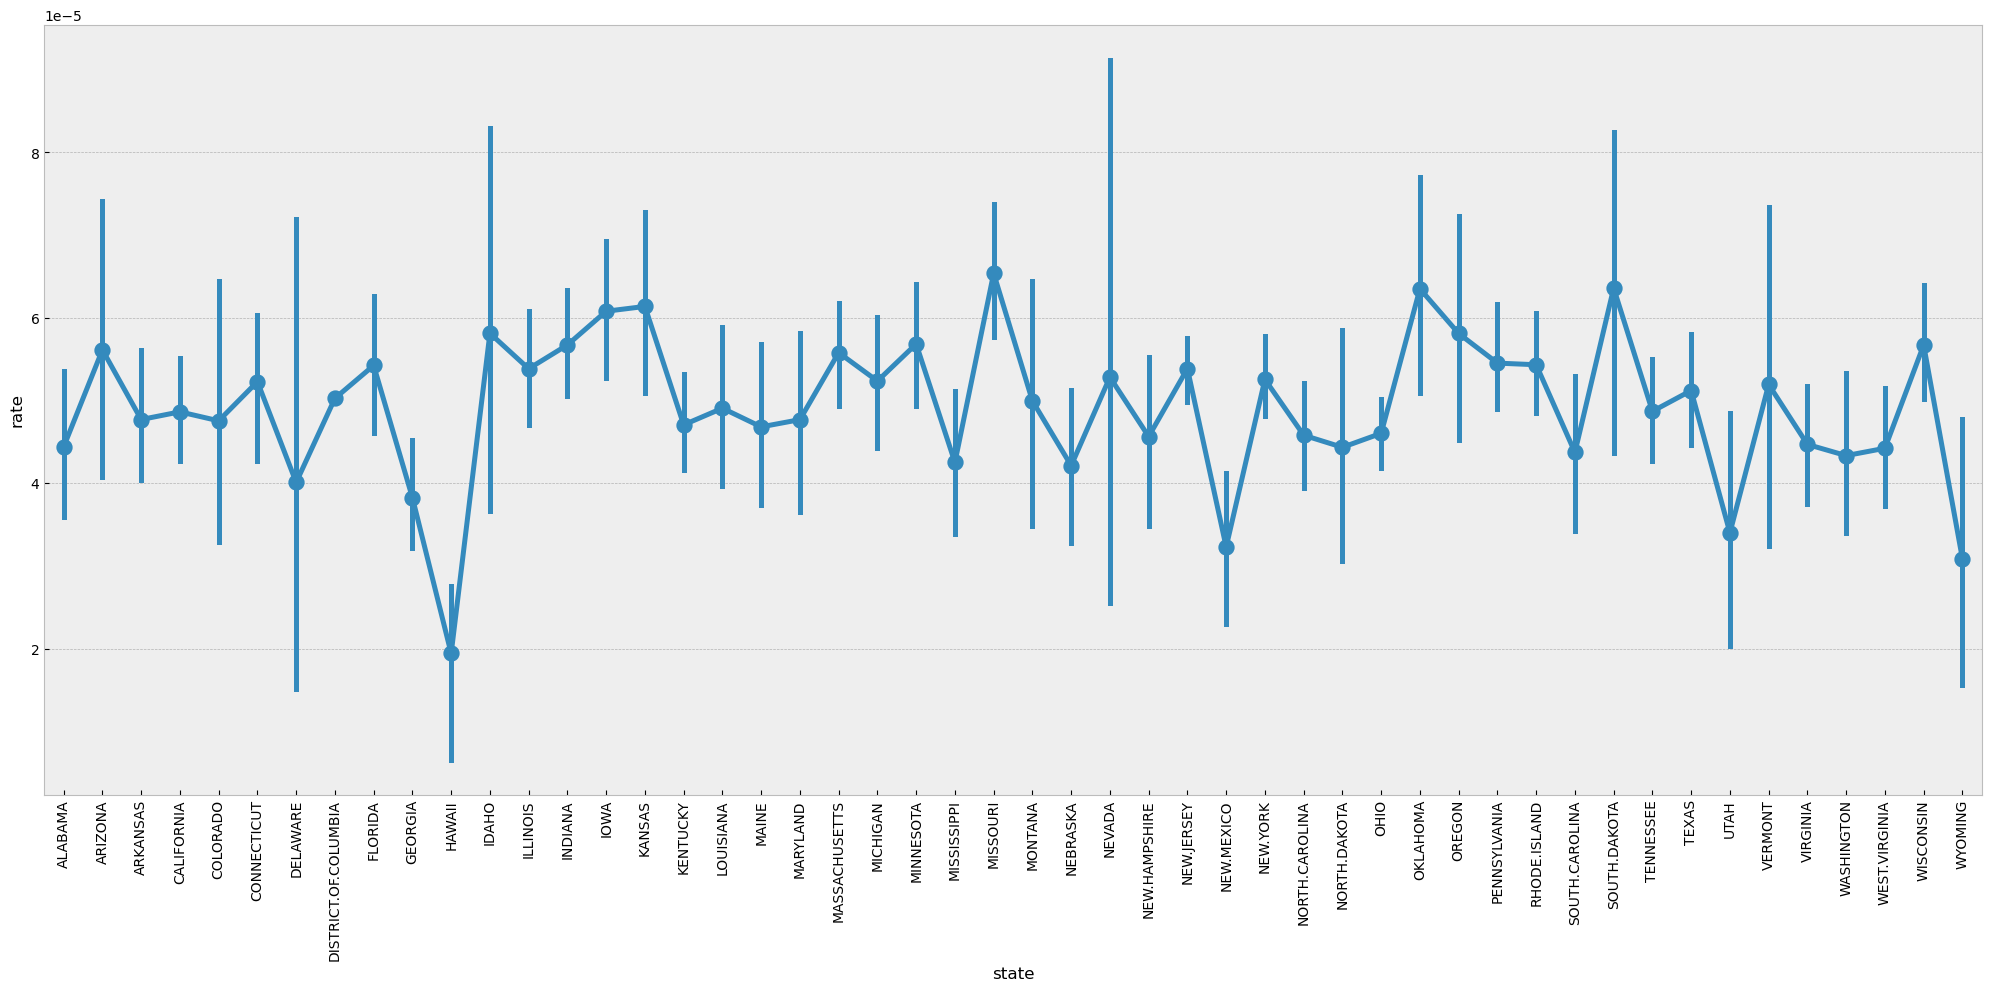

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
sns.pointplot(x = 'state', y = 'rate', data = df, ax=ax)
plt.xticks(rotation=90)
plt.show()

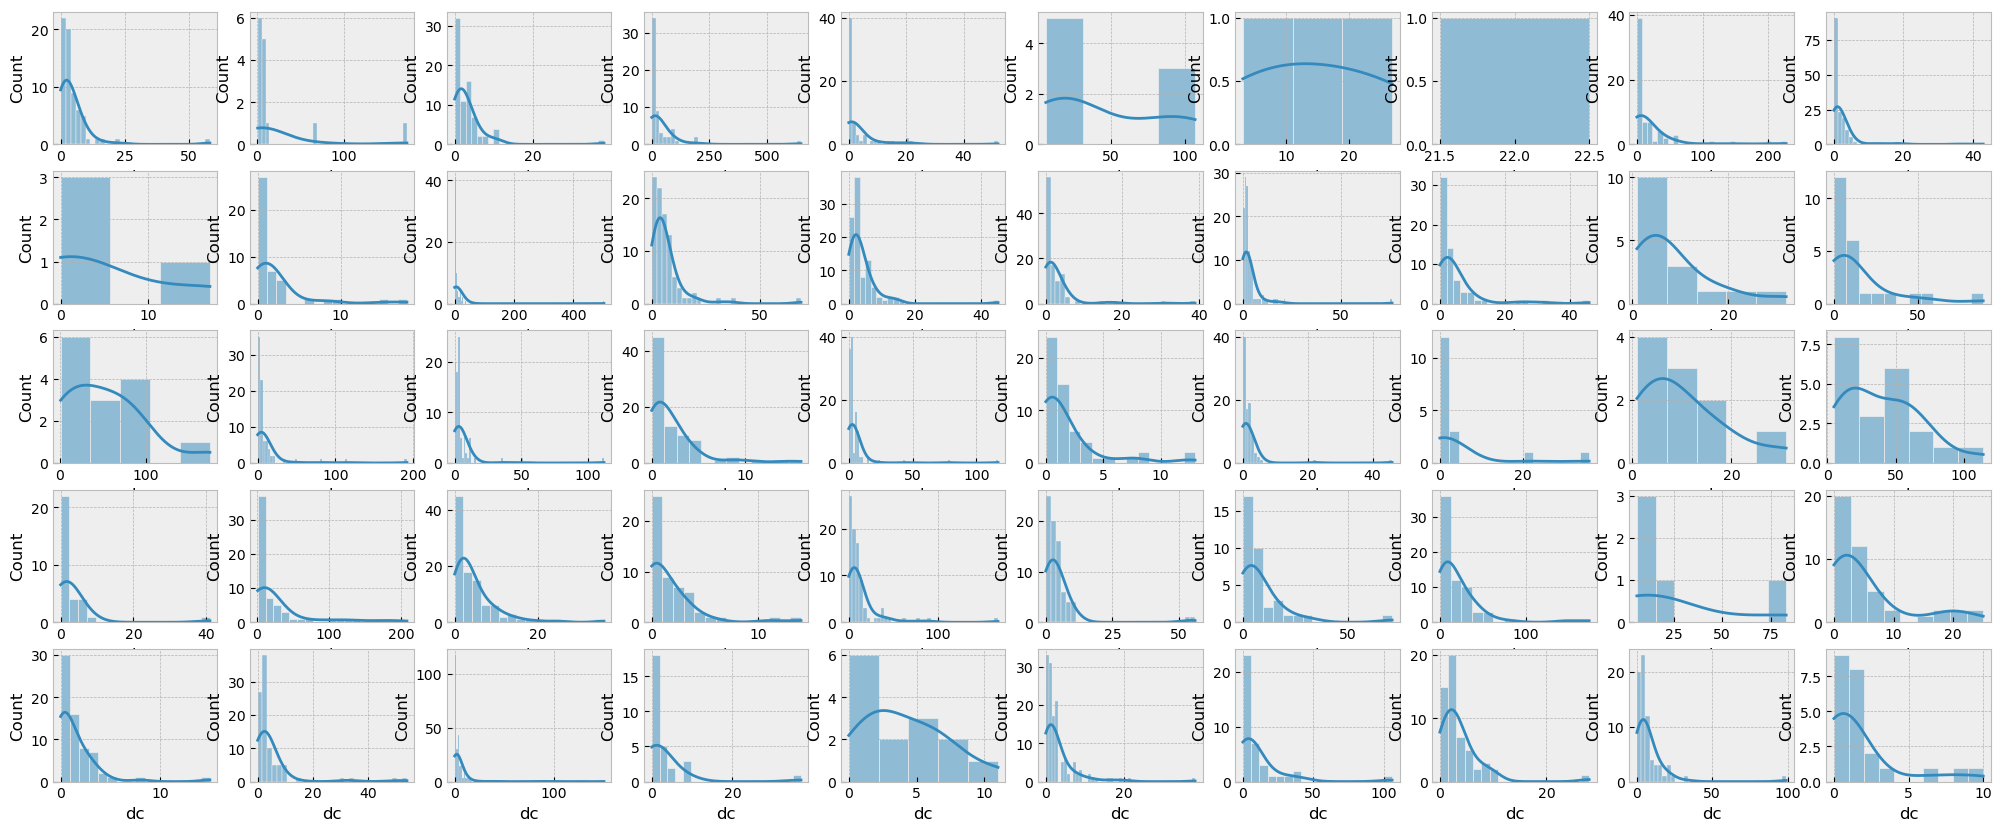

In [7]:
fig, ax = plt.subplots(5, 10, figsize=(25, 10))

for i, st in enumerate(df.state.unique()):
    sns.histplot(df.loc[df.state == st, 'dc'], kde=True, ax=ax[i//10, i%10])

# Zero-inflated
+ https://num.pyro.ai/en/stable/examples/zero_inflated_poisson.html

In [8]:
state_list = list(df['state'].unique())

location = []
for i in range(len(df)):
    location.append(state_list.index(df['state'].values.copy()[i]))

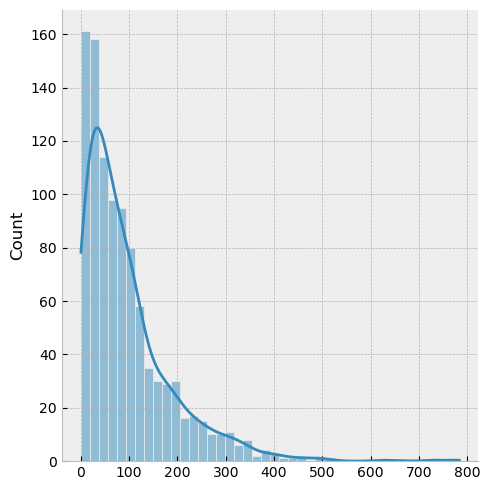

In [67]:
rng = np.random.default_rng(seed_split)
sns.displot(rng.negative_binomial(1, 0.01, size = 1000), kde=True)

In [10]:
df['pop'].describe()

count    3.110000e+03
mean     1.550087e+05
std      4.722345e+05
min      2.580000e+02
25%      2.238250e+04
50%      4.762800e+04
75%      1.146262e+05
max      1.526640e+07
Name: pop, dtype: float64

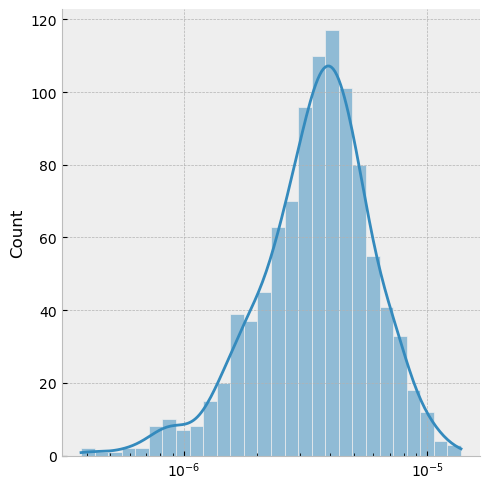

In [69]:
rng = np.random.default_rng(seed_split)
sns.displot(rng.beta(4, 1e6, size = 1000), kde=True, log_scale=(True, False))

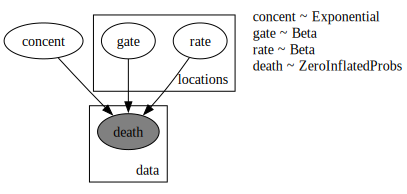

In [12]:
def model(location, population, death = None):
    num_locations = len(np.unique(location))
    concent = numpyro.sample('concent', dist.Exponential(1.0))

    with numpyro.plate('locations', num_locations):
        gate = numpyro.sample('gate', dist.Beta(1.0, 5.0))
        rate = numpyro.sample('rate', dist.Beta(4.0, 1e6))

    chosen_gate = jnp.take(gate, location.astype(int), axis = 0)  # need to be valid prob
    chosen_rate = jnp.take(rate, location.astype(int), axis = 0)
    chosen_mean = chosen_rate * population
    with numpyro.plate('data', len(location)):
        numpyro.sample('death', dist.ZeroInflatedNegativeBinomial2(
            concentration = concent,
            mean = chosen_mean * concent, # to make rate = 1/mean
            gate = chosen_gate
        ), obs = death)


data = dict()
data['death'] = df['dc'].values.copy()
data['location'] = np.array(location, dtype = int)
data['population'] = df['pop'].values.copy()

numpyro.render_model(
    model = model,
    model_args = (data.values()),
    render_params = True,
    render_distributions = True)

In [13]:
mcmc = _run_model(model, data)
mcmc.print_summary()
mcmc_dict['model'] = mcmc

/var/folders/zz/x65716_j4s7947htd3809l4h0000gn/T/ipykernel_57444/3267734172.py:43: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 3000/3000 [00:39<00:00, 75.06it/s, 31 steps of size 1.56e-01. acc. prob=0.90] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   concent     14.11      0.83     14.07     12.72     15.39    383.59      1.00
   gate[0]      0.04      0.03      0.03      0.00      0.09   5888.78      1.00
   gate[1]      0.05      0.05      0.04      0.00      0.12   7195.97      1.00
   gate[2]      0.03      0.03      0.03      0.00      0.07   7053.22      1.00
   gate[3]      0.02      0.02      0.01      0.00      0.04   6359.94      1.00
   gate[4]      0.03      0.03      0.02      0.00      0.07   6890.06      1.00
   gate[5]      0.07      0.07      0.05      0.00      0.16   6916.74      1.00
   gate[6]      0.11      0.10      0.08      0.00      0.25   6968.07      1.00
   gate[7]      0.14      0.12      0.11      0.00      0.32   7516.60      1.00
   gate[8]      0.03      0.03      0.02      0.00      0.07   6755.77      1.00
   gate[9]      0.03      0.02      0.02      0.00      0.06   6357.12      1.00
  gate[10]      0.15      0

In [14]:
mcmc = mcmc_dict['model']
_, rng_key = random.split(seed_jax_rng)
samples = mcmc.get_samples()

posterior_predictive = Predictive(model, samples)(
    rng_key, data['location'], data['population']
)

In [15]:
az_data = az.from_numpyro(mcmc)

In [16]:
pred_death = np.median(posterior_predictive['death'], axis = 0)

<Axes: ylabel='Count'>

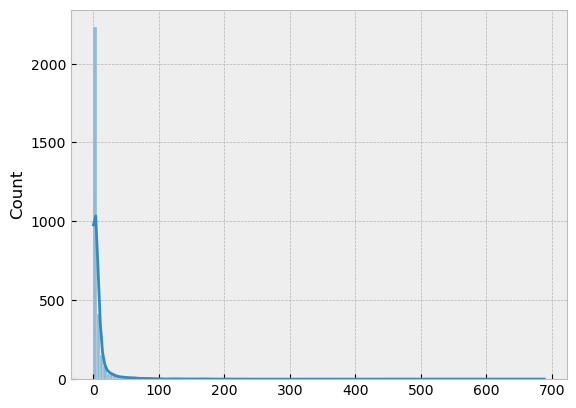

In [17]:
sns.histplot(pred_death, kde = True, binwidth=5)

<Axes: xlabel='dc', ylabel='Count'>

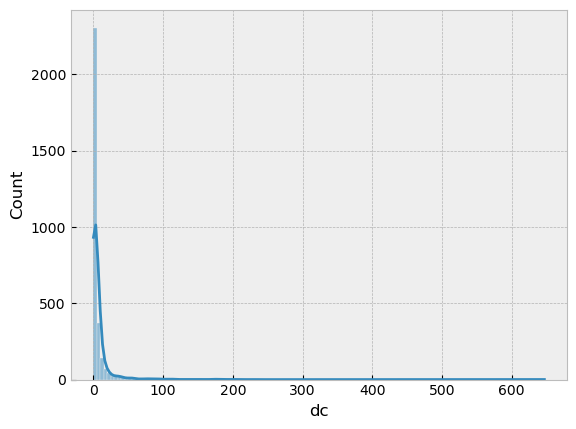

In [18]:
sns.histplot(df.dc, kde = True, binwidth=5)

In [19]:
np.where(posterior_predictive['death'][0] == 0, True, False).sum()

np.int64(744)

In [20]:
df.loc[df.dc == 0].shape

(594, 7)

In [21]:
def find_loc(i: int):
    sns.histplot(posterior_predictive['death'][:, i], kde = True)
    plt.vlines(df.dc[i], 0, 100, color = 'red')
    plt.title(f'Location {i}')

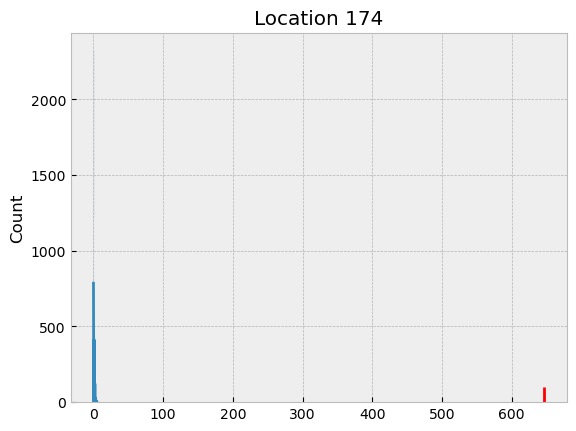

In [71]:
find_loc(174)

In [23]:
df.loc[df.dc >= 200, :]

,state,Location,dc,dc.2,pop,pop.2,rate
174,CALIFORNIA,"Los Angeles County, California",647,598,15266402,16607891,0.000042
331,FLORIDA,"Miami-Dade County, Florida",227,207,3278943,3465460,0.000069
578,ILLINOIS,"Cook County, Illinois",503,549,9080516,8901701,0.000055
1835,NEW.YORK,"Queens County, New York",208,186,3279555,3122769,0.000063


# Prediction

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [28]:
X = df[['state', 'pop']]
y = df['dc']
X_dum = pd.get_dummies(X, columns = ['state'], drop_first = True)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed_split)
X_train_dum, X_test_dum, y_train_dum, y_test_dum = train_test_split(X_dum, y, test_size = 0.2, random_state = seed_split)

In [38]:
scaler = StandardScaler()
X_train_dum[['pop']] = scaler.fit_transform(X_train_dum[['pop']])
X_test_dum[['pop']] = scaler.transform(X_test_dum[['pop']])

## Linear Regression

In [40]:
lr = LinearRegression()
lr.fit(X_train_dum, y_train_dum)

LinearRegression()

In [41]:
print(f'MSE: {mean_squared_error(y_test_dum, lr.predict(X_test_dum))}\n R2: {r2_score(y_test_dum, lr.predict(X_test_dum))}')

MSE: 37.38694708102581
 R2: 0.9660449175150768


## Naive Bayes

In [44]:
nb = GaussianNB()
nb.fit(X_train_dum, y_train_dum)

GaussianNB()

In [46]:
print(f'MSE: {mean_squared_error(y_test_dum, nb.predict(X_test_dum))}\n R2: {r2_score(y_test_dum, nb.predict(X_test_dum))}')

MSE: 1603.072347266881
 R2: -0.45592133165564697


## Bayesian

In [53]:
state_list = list(df['state'].unique())

train_location = []
for i in range(len(X_train)):
    train_location.append(state_list.index(X_train['state'].values.copy()[i]))

test_location = []
for i in range(len(X_test)):
    test_location.append(state_list.index(X_test['state'].values.copy()[i]))

In [54]:
train_data = dict()
train_data['death'] = y_train.values.copy()
train_data['location'] = np.array(train_location, dtype = int)
train_data['population'] = X_train['pop'].values.copy()

mcmc_com = _run_model(model, train_data)
mcmc_com.print_summary()

/var/folders/zz/x65716_j4s7947htd3809l4h0000gn/T/ipykernel_57444/3267734172.py:43: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 3000/3000 [00:31<00:00, 93.97it/s, 31 steps of size 1.73e-01. acc. prob=0.90] 


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   concent     13.50      0.80     13.46     12.28     14.86    301.20      1.01
   gate[0]      0.04      0.03      0.03      0.00      0.08   5180.42      1.00
   gate[1]      0.07      0.06      0.05      0.00      0.15   4832.58      1.00
   gate[2]      0.04      0.03      0.03      0.00      0.08   5282.24      1.00
   gate[3]      0.02      0.02      0.02      0.00      0.05   5092.67      1.00
   gate[4]      0.03      0.03      0.02      0.00      0.08   5196.56      1.00
   gate[5]      0.08      0.07      0.06      0.00      0.18   5314.21      1.00
   gate[6]      0.11      0.10      0.08      0.00      0.25   4478.81      1.00
   gate[7]      0.14      0.12      0.11      0.00      0.33   5475.65      1.00
   gate[8]      0.04      0.03      0.03      0.00      0.09   5663.22      1.00
   gate[9]      0.04      0.03      0.03      0.00      0.08   5435.01      1.00
  gate[10]      0.15      0

In [56]:
test_data = dict()
test_data['location'] = np.array(test_location, dtype = int)
test_data['population'] = X_test['pop'].values.copy()

In [57]:
_, rng_key = random.split(seed_jax_rng)
samples_com = mcmc_com.get_samples()

posterior_predictive = Predictive(model, samples_com)(
    rng_key, test_data['location'], test_data['population']
)

In [62]:
y_pred = posterior_predictive['death'].mean(axis = 0)

In [63]:
print(f'MSE: {mean_squared_error(y_test, y_pred)}\n R2: {r2_score(y_test, y_pred)}')

MSE: 17.57674742403435
 R2: 0.9840366840362549
